<a href="https://colab.research.google.com/github/amedyukhina/biomassters/blob/main/biomassters_all_times_unet_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
numpy==1.21.6
torch
torchvision
scikit-image
matplotlib
pytorch_lightning
segmentation_models_pytorch
monai==0.9.1
wandb

Writing requirements.txt


In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 800 kB 73.9 MB/s 
     |████████████████████████████████| 102 kB 13.1 MB/s 
     |████████████████████████████████| 990 kB 61.4 MB/s 
     |████████████████████████████████| 1.9 MB 57.1 MB/s 
     |████████████████████████████████| 512 kB 62.1 MB/s 
     |████████████████████████████████| 125 kB 75.4 MB/s 
     |████████████████████████████████| 58 kB 7.4 MB/s 
     |████████████████████████████████| 376 kB 62.0 MB/s 
     |████████████████████████████████| 174 kB 72.6 MB/s 
     |████████████████████████████████| 182 kB 74.6 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 173 kB 76.9 MB/s 
     |████████████████████████████████| 168 kB 80.1 MB/s 
     |████████████████████████████████| 168 kB 70.7 MB/s 
     |███████████████████████████████

In [4]:
from google.colab import drive
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from skimage import io

from cachetools import cached, TTLCache

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose, Normalize
import torch.nn.functional as F
from torch import nn
import segmentation_models_pytorch as smp
from torchvision.io import read_image
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
import warnings
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import shutil
from scipy import ndimage
from monai.networks.layers import Norm
from monai.networks.nets import UNet, DynUNet
import wandb

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
with open('gdrive/MyDrive/Personal/wandb_apikey') as f:
    key = f.read()

os.environ['WANDB_API_KEY'] = key.rstrip('\n')

### Prepare list of chip IDs

In [7]:
feature_path = 'gdrive/MyDrive/biomassters/info/features_metadata.csv'
data_path = 'gdrive/MyDrive/biomassters/data/'
train_img_dir = data_path + 'train_features'
test_img_dir = data_path + 'test_features'
label_dir = data_path + 'train_agbm'
output_dir = 'predicted'
model_checkpoint_path = 'gdrive/MyDrive/biomassters/models/'
MODE = 'S2'
ntrain = 200
nval = 20

In [8]:
df = pd.read_csv(feature_path)
df_pred = df[df['split'] == 'test'].reset_index(drop=True)
pred_ids = np.unique(df_pred['chip_id'])
df = df[df['split'] == 'train'].reset_index(drop=True)
all_ids = np.unique(df['chip_id'])

np.random.seed(42)
np.random.shuffle(all_ids)
train_ids = all_ids[:ntrain]
val_ids = all_ids[ntrain:ntrain+nval]

### Set up data loading

In [9]:
cache = TTLCache(maxsize=1000, ttl=86400)

In [10]:
@cached(cache)
def get_image(fn):
    if os.path.exists(fn):
        img = io.imread(fn)
        if img.shape[-1] < 20:
            img = np.moveaxis(img, -1, 0)
    else:
        img = np.zeros((len(MEANS), 256, 256))
    return img

In [11]:
MEANS, STDS = np.load(data_path + rf'{MODE.lower()}_mean_std.npy')

### Define a dataset

In [12]:
class SentinelDataset2(Dataset):
    def __init__(self, chip_ids, img_dir, label_dir=None, 
                 transform=None):
        self.chip_ids = chip_ids
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.chip_ids)

    def __getitem__(self, idx):
        image = []
        for month in range(12):
            img = get_image(os.path.join(self.img_dir, 
                                          rf"{self.chip_ids[idx]}_{MODE}_{month:02d}.tif"))
            img = torch.tensor(img.astype(np.float32))
            img = (img - torch.tensor(MEANS).unsqueeze(1).unsqueeze(1))/torch.tensor(STDS).unsqueeze(1).unsqueeze(1)
            image.append(img)
        image = torch.stack(image)
        t, c, h, w = image.shape
        
        if self.label_dir is not None:
            label = get_image(os.path.join(self.label_dir, 
                                           rf"{self.chip_ids[idx]}_agbm.tif"))
            label = ndimage.median_filter(label[0], 3)
            label = torch.tensor(label.astype(np.float32)).unsqueeze(0)
        else:
            label = None

        
        if self.transform:
            image = self.transform(torch.concat([image.reshape(t*c, h, w), label]))
            label = image[-1:]
            image = image[:-1].reshape(t, c, h, w)
            
        return image, label

In [13]:
train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.RandomRotation(degrees=180)
    ])


In [14]:
train_ds = SentinelDataset2(train_ids, train_img_dir, label_dir, 
                            transform=train_transforms
                            )
val_ds = SentinelDataset2(val_ids, train_img_dir, label_dir)
train_dataloader = DataLoader(train_ds, batch_size=8, 
                              shuffle=True, num_workers = 2)
valid_dataloader = DataLoader(val_ds, batch_size=8, 
                              shuffle=False, num_workers = 2)

test_ds = SentinelDataset2(pred_ids, test_img_dir)
test_dataloader = DataLoader(test_ds, batch_size=2, 
                             shuffle=True, num_workers = 2)

In [15]:
# torch.random.manual_seed(42)

In [16]:
# %%time
# imgs, labels = next(iter(train_dataloader))

In [17]:
# imgs.shape, labels.shape

In [18]:
# cols = 5
# rows = 2
# s = 3
# fig, axes = plt.subplots(rows, cols, figsize=(s*cols, s*rows))
# for img, ax in zip(imgs[0][0], axes.ravel()):
#     ax.imshow(img.numpy())

In [19]:
# # Show ground truth
# plt.imshow(labels[0][0].numpy())

### Define the model and the training pipeline

In [20]:
def train_val_step(batch, model):
    img, label = batch
    predicted = model(img)
    loss = F.mse_loss(predicted, label)
    return loss


class Sentinel2Model(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        loss = train_val_step(batch, self.model)
        self.log("train/loss", loss)
        self.log("train/rmse", torch.sqrt(loss))
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = train_val_step(batch, self.model)
        self.log("valid_loss", loss)
        self.log("valid_rmse", torch.sqrt(loss))
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
    def forward(self, x):
        return self.model(x)

In [21]:
n_channels = (32, 64, 128, 256, 512)
strides = (2, 2, 1, 1)

class Unet3D(nn.Module):
    def __init__(self, n_channels, strides):
        super(Unet3D, self).__init__()
        self.unet = UNet(
            spatial_dims=3,
            in_channels=len(MEANS),
            out_channels=1,
            kernel_size=(3, 5, 5),
            channels=n_channels,
            strides=strides,
            num_res_units=2,
            norm=Norm.BATCH,
            )
        self.conv = nn.Conv3d(12, 1, kernel_size=1, stride=1, padding=0)

    def forward(self, img):
        out = self.unet(torch.moveaxis(img, 1, 2))
        return self.conv(torch.moveaxis(out, 1, 2)).squeeze(1)


base_model = Unet3D(n_channels, strides)

In [22]:
s2_model = Sentinel2Model(base_model)

In [22]:
wandb_logger = WandbLogger(project='BioMassters_all_timepoints')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: amedyukh. Use `wandb login --relogin` to force relogin


In [23]:
 checkpoint_callback = ModelCheckpoint(
     monitor='valid_rmse',
     dirpath=os.path.join(model_checkpoint_path, wandb.run.name),
     filename='{epoch:02d}-{valid_rmse:.2f}')

In [24]:
# Initialize a trainer
trainer = Trainer(
    accelerator="gpu",
    max_epochs=30,
    logger=[wandb_logger],
    callbacks=[checkpoint_callback],
    log_every_n_steps=5
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Train

In [25]:
%%time
# Train the model ⚡
torch.random.manual_seed(42)
trainer.fit(s2_model, train_dataloaders=train_dataloader, 
            val_dataloaders=valid_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | Unet3D | 44.5 M
---------------------------------
44.5 M    Trainable params
0         Non-trainable params
44.5 M    Total params
177.813   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


CPU times: user 1h 52min 41s, sys: 1min 44s, total: 1h 54min 25s
Wall time: 2h 45s


### Show example predictions

In [24]:
# fn = os.listdir(os.path.join(model_checkpoint_path, wandb.run.name))[0]
fn = os.listdir(os.path.join(model_checkpoint_path, 'usual-jazz-6'))[0]
s2_model.load_state_dict(torch.load(os.path.join(model_checkpoint_path,'usual-jazz-6', fn))['state_dict'])
s2_model.eval().cuda();

In [ ]:
imgs, labels = next(iter(valid_dataloader))
pred = s2_model(imgs.cuda())

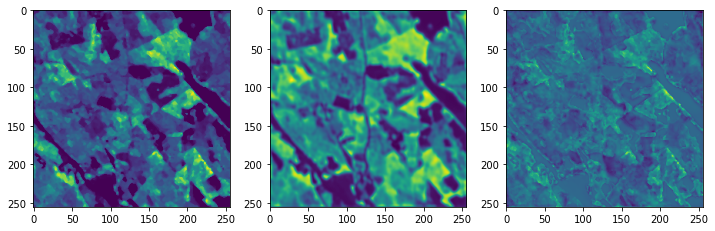

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(ndimage.median_filter(labels[0].numpy()[0], 3))
axes[1].imshow(pred[0].cpu().detach().numpy()[0])
axes[2].imshow(ndimage.median_filter(labels[0].numpy()[0], 3) - pred[0].cpu().detach().numpy()[0])

### Prediction

In [29]:
os.makedirs(output_dir, exist_ok=True)
for chip_id in tqdm(pred_ids):
    image = []
    for month in range(12):
        img = get_image(os.path.join(test_img_dir, 
                                      rf"{chip_id}_{MODE}_{month:02d}.tif"))
        img = torch.tensor(img.astype(np.float32))
        img = (img - torch.tensor(MEANS).unsqueeze(1).unsqueeze(1))/torch.tensor(STDS).unsqueeze(1).unsqueeze(1)
        image.append(img)
    image = torch.stack(image)

    pred = s2_model(image.unsqueeze(0).cuda())
    img = pred.squeeze().cpu().detach().numpy()
    io.imsave(f"{output_dir}/{chip_id}_agbm.tif", img)

In [30]:
shutil.make_archive('submission', 'zip', output_dir)

In [31]:
from google.colab import files
files.download('submission.zip')